In [1]:
import cftime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.stats import genextreme as gev
from scipy import stats
import xclim as xc
from xclim import sdba
from xclim.sdba import nbutils

from unseen import fileio
from unseen import eva
from unseen import moments
from unseen import similarity
from unseen import stability
from unseen import bias_correction
from unseen import time_utils

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xclim/sdba/__init__.py:22: FutureWarning: The SDBA submodule is in the process of being split from `xclim` in order to facilitate development and effective maintenance of the SDBA utilities. The `xclim.sdba` functionality will change in the future. For more information, please visit https://xsdba.readthedocs.io/en/latest/.
  warnings.warn(


In [2]:
lat = {}
lon = {}

lat['Katherine'] = -14.5
lon['Katherine'] = 132.3

lat['Surat'] = -27.2
lon['Surat'] = 149.1

lat['Miena'] = -42.0
lon['Miena'] = 146.7

In [3]:
location = 'Surat'

### Observations

In [4]:
rx1day_obs_file = '/Users/irv033/Desktop/unseen-bias/rx1day_AGCD-CSIRO_1901-2024_annual-jul-to-jun_AUS300i.nc'

In [5]:
ds_obs = fileio.open_dataset(rx1day_obs_file)

In [6]:
da_obs = ds_obs['pr'].sel({'lat': lat[location], 'lon': lon[location]}, method='nearest')

In [7]:
da_obs = da_obs.compute()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)


In [8]:
df_obs = da_obs.to_dataframe()

In [9]:
ranked_years = df_obs.sort_values(by='pr', ascending=False)
print(ranked_years.head(n=10))

                      lat    lon  event_time         pr
time                                                   
2010-06-30 00:00:00 -27.0  149.5  2010-03-02  97.061157
1959-06-30 00:00:00 -27.0  149.5  1959-02-18  89.027512
1937-06-30 00:00:00 -27.0  149.5  1937-03-15  88.573204
1956-06-30 00:00:00 -27.0  149.5  1956-01-21  85.715691
1984-06-30 00:00:00 -27.0  149.5  1983-11-21  62.422421
1972-06-30 00:00:00 -27.0  149.5  1971-12-27  59.864838
1953-06-30 00:00:00 -27.0  149.5  1953-02-16  57.556465
2011-06-30 00:00:00 -27.0  149.5  2010-12-27  56.220860
1981-06-30 00:00:00 -27.0  149.5  1981-06-01  55.627785
1940-06-30 00:00:00 -27.0  149.5  1940-03-18  55.378033


In [10]:
linear_fit_obs = np.polyfit(da_obs.time.dt.year.values, da_obs.values, 1)
linear_data_obs = np.polyval(linear_fit_obs, da_obs.time.dt.year.values)

In [11]:
base_mean_obs = da_obs.sel(time=slice('1972-01-01', '2018-12-31')).mean().values

In [12]:
da_obs_detrended = (da_obs - linear_data_obs) + base_mean_obs
da_obs_detrended.attrs = da_obs.attrs

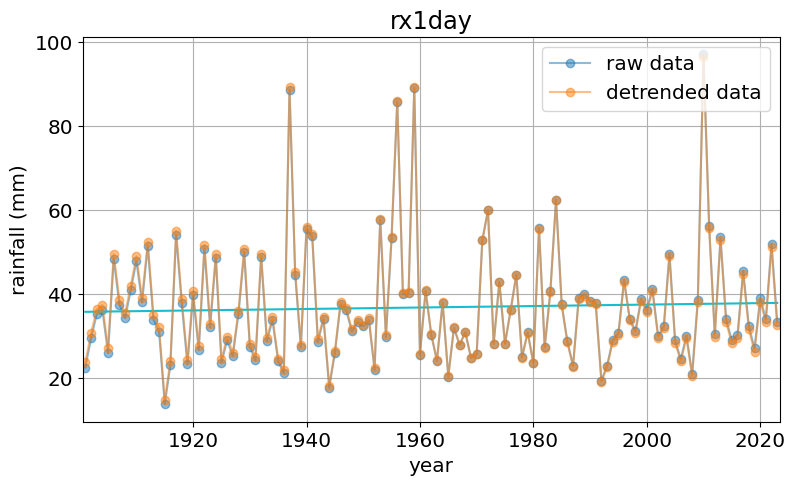

In [13]:
fig, ax = plt.subplots(figsize=[9, 5])
years = da_obs['time'].dt.year.values
plt.plot(years, da_obs.values, marker='o', label='raw data', color='tab:blue', alpha=0.5)
plt.plot(years, linear_data_obs, color='tab:cyan')
plt.plot(years, da_obs_detrended.values, marker='o', label='detrended data', color='tab:orange', alpha=0.5)
plt.xlim(years[0] - 0.5, years[-1] + 0.5)
plt.title('rx1day')
plt.ylabel('rainfall (mm)')
plt.xlabel('year')
plt.legend()
plt.grid()

In [14]:
gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended = eva.fit_gev(da_obs_detrended.values)
print(f'Shape parameter: {gev_shape_obs_detrended:.2f}')
print(f'Location parameter: {gev_loc_obs_detrended:.2f}')
print(f'Scale parameter: {gev_scale_obs_detrended:.2f}')

Shape parameter: -0.12
Location parameter: 30.52
Scale parameter: 9.02


### Model data

In [15]:
rx1day_model_file = '/Users/irv033/Desktop/unseen-bias/rx1day_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_AUS300i.nc'

In [16]:
ds_model = fileio.open_dataset(rx1day_model_file)

In [17]:
da_model = ds_model['pr'].sel({'lat': lat[location], 'lon': lon[location]}, method='nearest')

In [18]:
da_model = da_model.compute()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)


In [19]:
da_model_stacked = da_model.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [20]:
linear_fit_model = np.polyfit(da_model_stacked.time.dt.year.values, da_model_stacked.values, 1)
linear_data_model = np.polyval(linear_fit_model, np.unique(da_model_stacked.time.dt.year.values))

In [21]:
da_model_stacked_base = time_utils.select_time_period(da_model_stacked.copy(), ['1972-01-01', '2018-12-31'])
base_mean_model = da_model_stacked_base.mean().values

In [22]:
value_year_pairs = np.column_stack((da_model_stacked.values, da_model_stacked.time.dt.year.values))
detrended_data = []
for value, year in value_year_pairs:
    af = np.polyval(linear_fit_model, year)
    detrended_value = value - af + base_mean_model
    detrended_data.append(detrended_value)
detrended_data = np.array(detrended_data)

In [23]:
da_model_detrended_stacked = da_model_stacked * 0 + detrended_data
da_model_detrended_stacked.attrs = da_model_stacked.attrs

In [24]:
da_model_detrended = da_model_detrended_stacked.unstack()

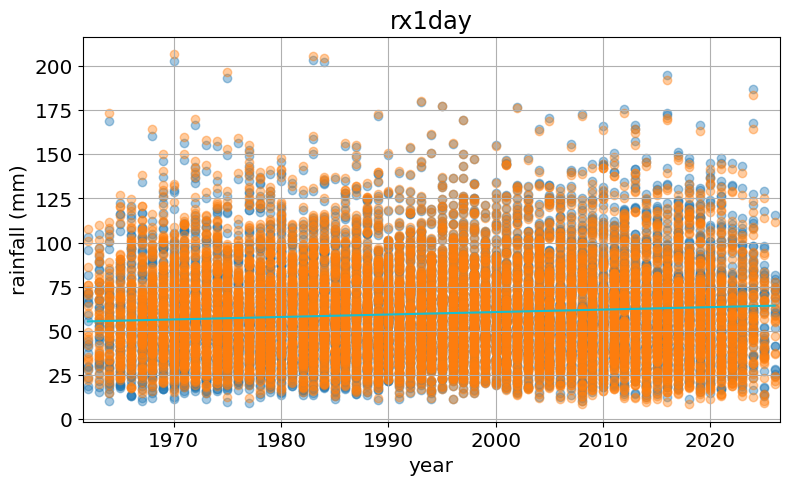

In [25]:
fig, ax = plt.subplots(figsize=[9, 5])
years = da_model_stacked['time'].dt.year.values
unique_years = np.unique(da_model_stacked.time.dt.year.values)
plt.scatter(years, da_model_stacked.values, marker='o', color='tab:blue', alpha=0.4, label='raw data')
plt.plot(unique_years, linear_data_model, color='tab:cyan')
plt.scatter(years, da_model_detrended_stacked.values, marker='o', color='tab:orange', alpha=0.4, label='detrended data')
plt.xlim(unique_years[0] - 0.5, unique_years[-1] + 0.5)
plt.title('rx1day')
plt.ylabel('rainfall (mm)')
plt.xlabel('year')
#plt.legend()
plt.grid()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


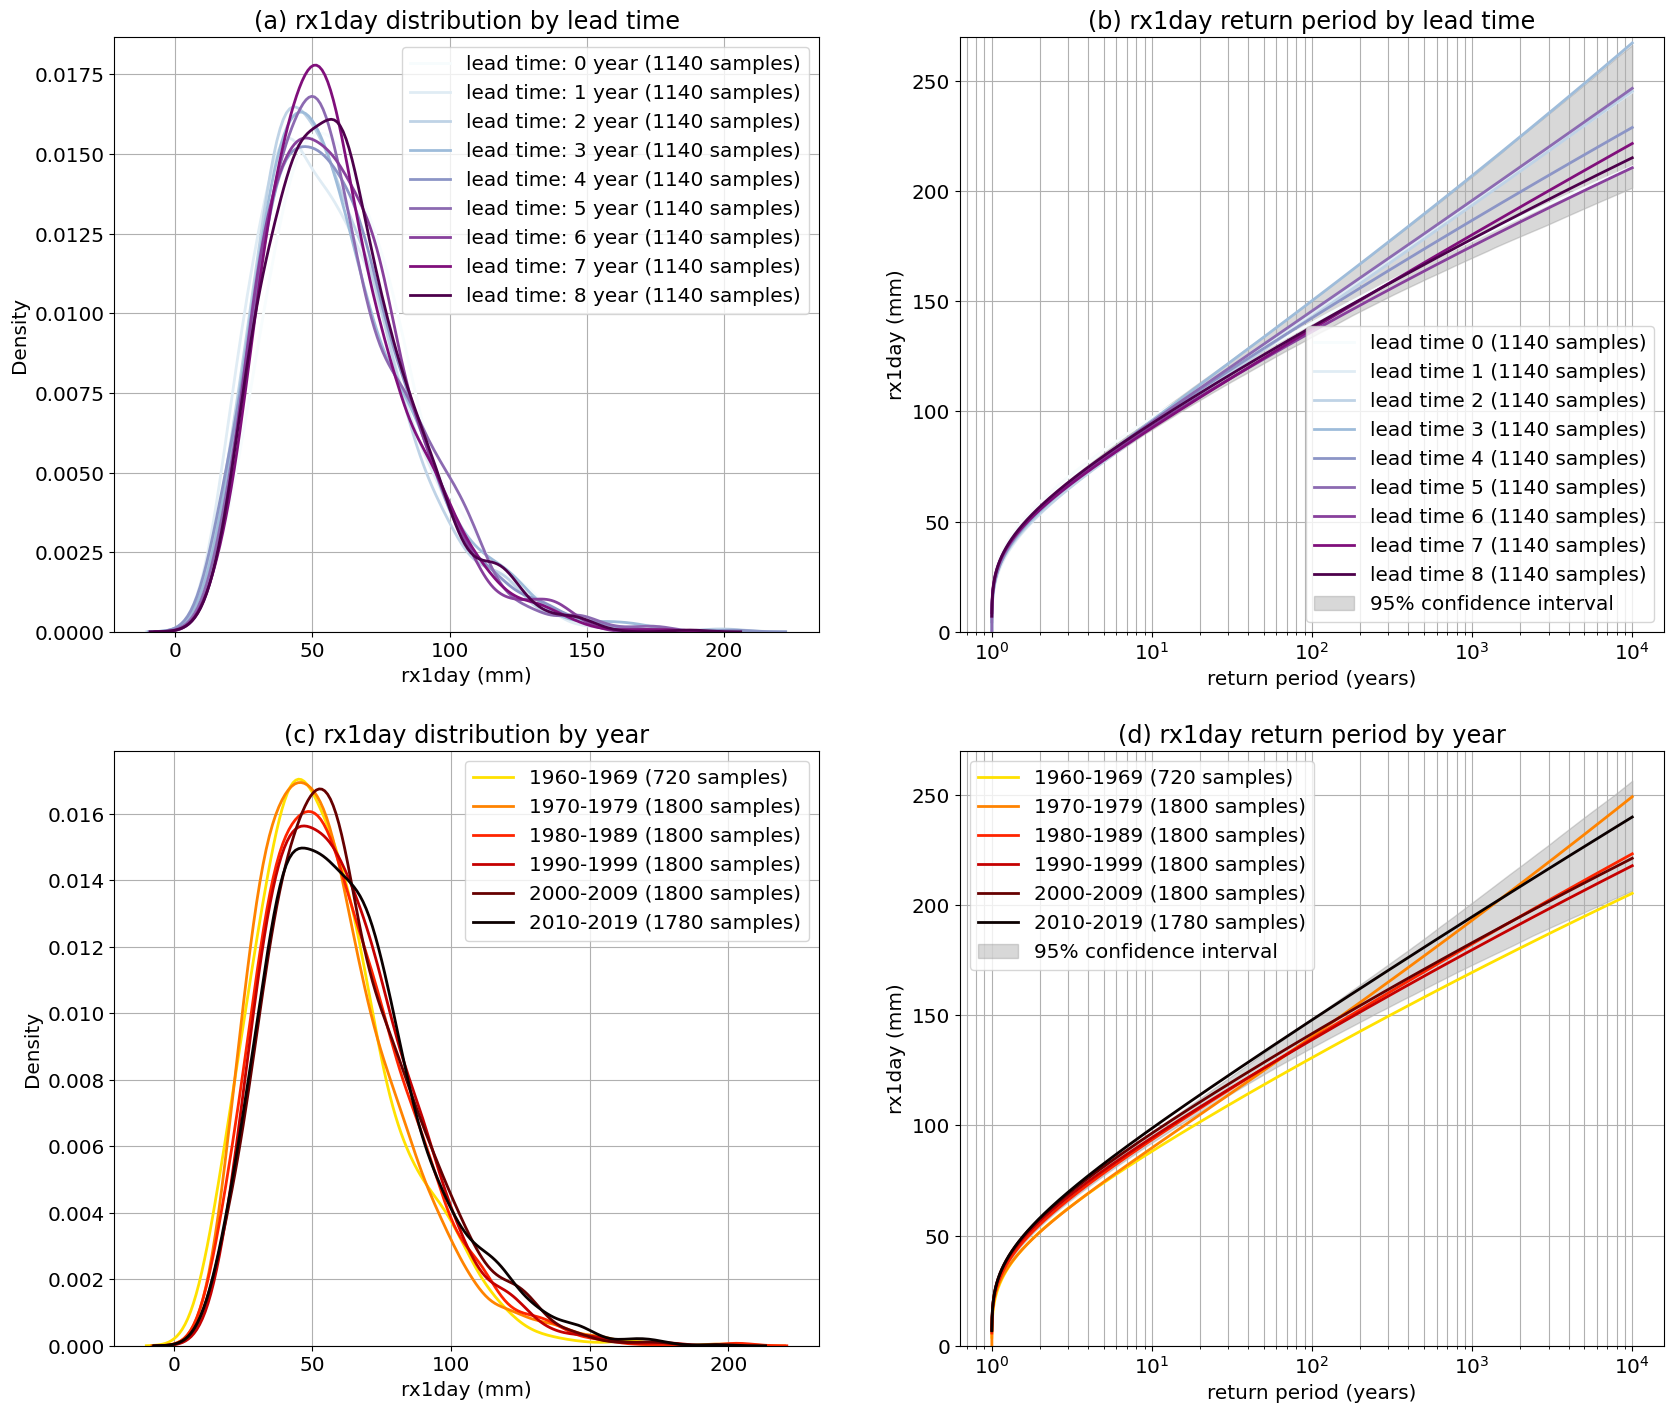

In [69]:
stability.create_plot(
    da_model,
    'rx1day',
    [1960, 1970, 1980, 1990, 2000, 2010],
    uncertainty=True,
    return_method='gev',
    units='rx1day (mm)',
    ylim=(0, 270),
)

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


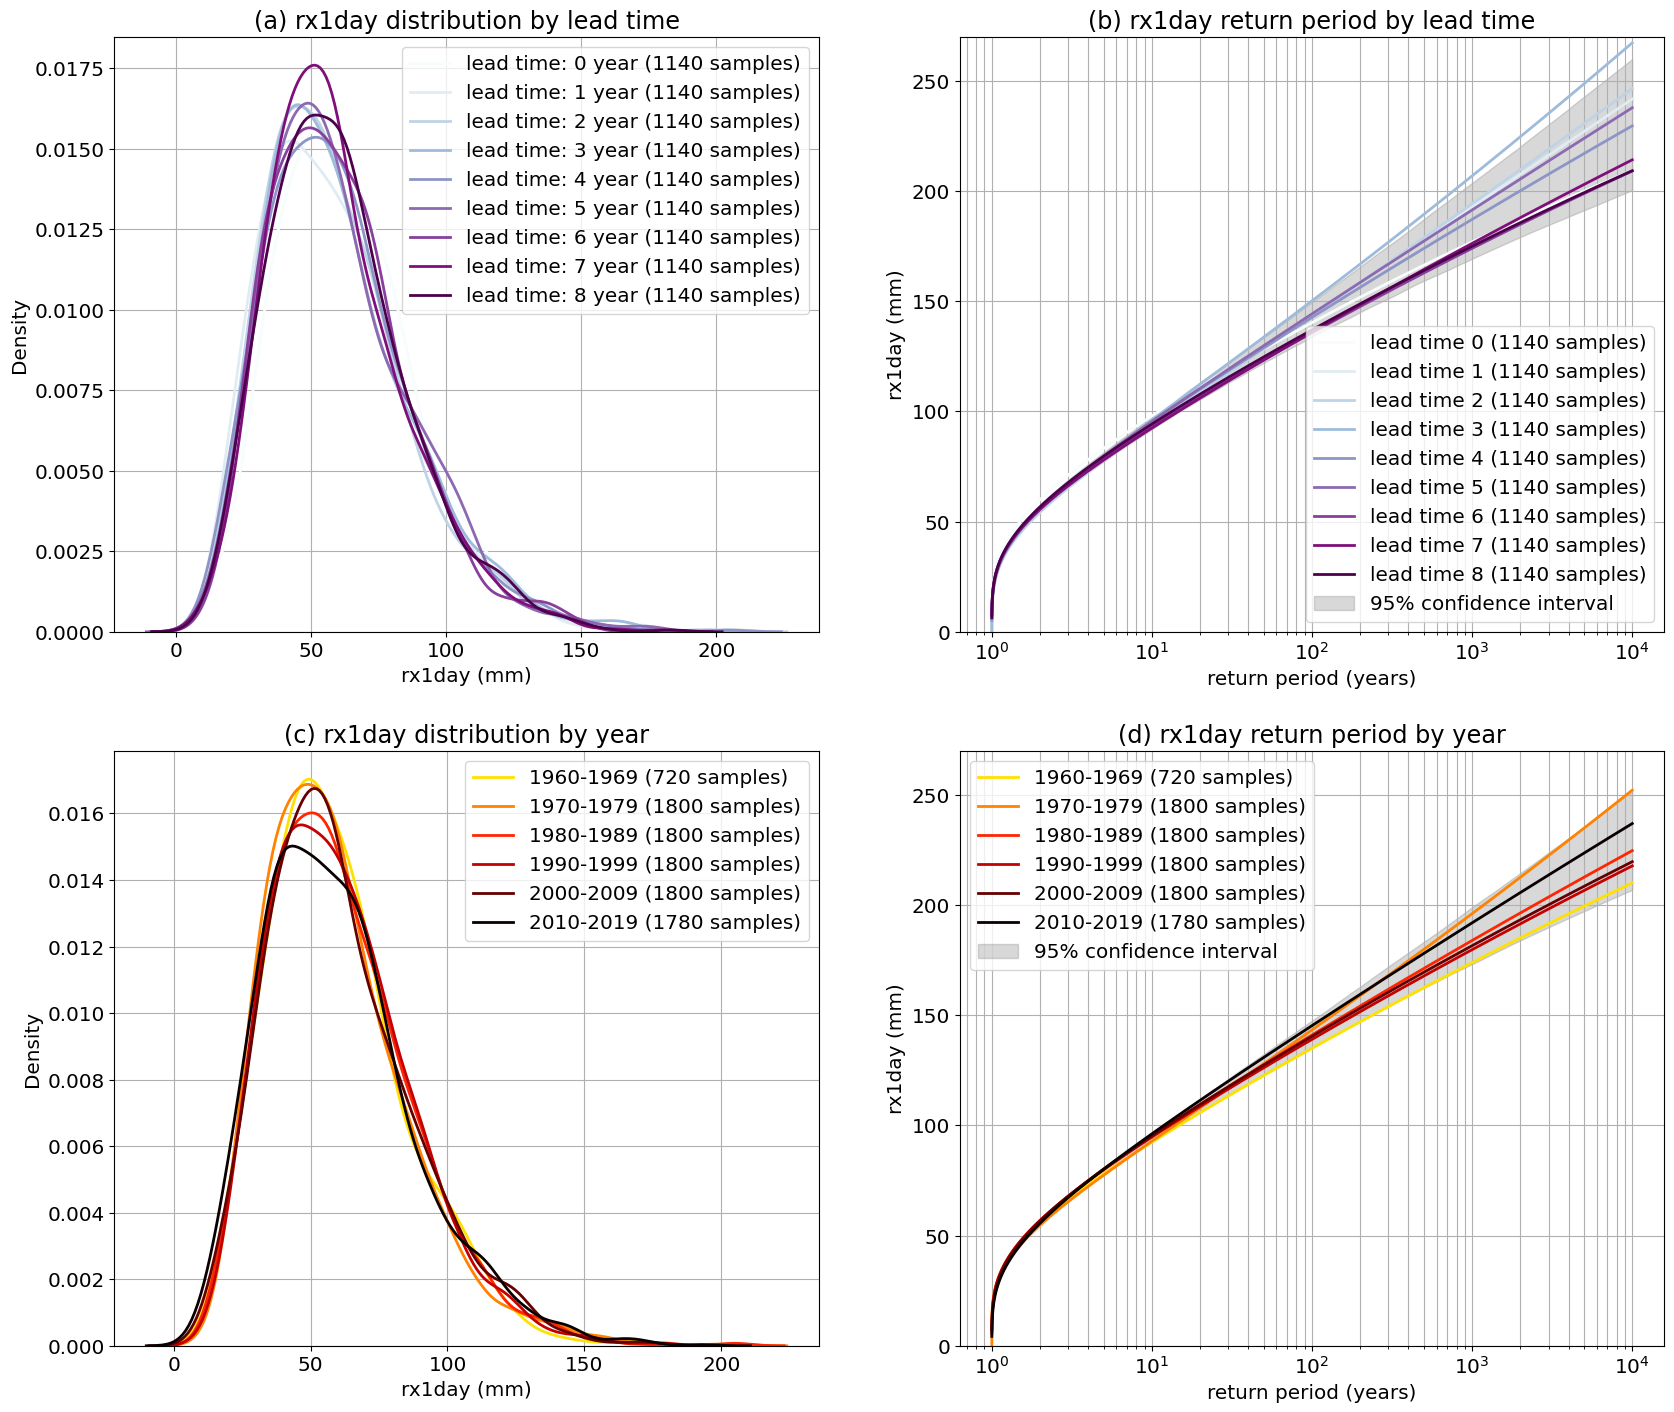

In [70]:
stability.create_plot(
    da_model_detrended,
    'rx1day',
    [1960, 1970, 1980, 1990, 2000, 2010],
    uncertainty=True,
    return_method='gev',
    units='rx1day (mm)',
    ylim=(0, 270),
)

In [28]:
gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended = eva.fit_gev(da_model_detrended_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended:.2f}')
print(f'Location parameter: {gev_loc_model_detrended:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended:.2f}')

Shape parameter: 0.02
Location parameter: 48.30
Scale parameter: 21.03


### Mean correction

#### Additive

In [29]:
bias_mean_add = bias_correction.get_bias(
    da_model_detrended,
    da_obs_detrended,
    'additive',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [30]:
da_model_detrended_bc_mean_add = bias_correction.remove_bias(da_model_detrended, bias_mean_add, 'additive')

In [31]:
da_model_detrended_bc_mean_add = da_model_detrended_bc_mean_add.compute()

In [32]:
da_model_detrended_bc_mean_add_stacked = da_model_detrended_bc_mean_add.dropna('lead_time').stack(
    {'sample': ['ensemble', 'init_date', 'lead_time']}
)

In [33]:
gev_shape_model_detrended_bc_mean_add, gev_loc_model_detrended_bc_mean_add, gev_scale_model_detrended_bc_mean_add = eva.fit_gev(da_model_detrended_bc_mean_add_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_mean_add:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_mean_add:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_mean_add:.2f}')

Shape parameter: 0.02
Location parameter: 24.53
Scale parameter: 21.03


#### Multiplicative

In [34]:
bias_mean_mulc = bias_correction.get_bias(
    da_model_detrended,
    da_obs_detrended,
    'multiplicative',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [35]:
da_model_detrended_bc_mean_mulc = bias_correction.remove_bias(da_model_detrended, bias_mean_mulc, 'multiplicative')
da_model_detrended_bc_mean_mulc = da_model_detrended_bc_mean_mulc.compute()

In [36]:
da_model_detrended_bc_mean_mulc_stacked = da_model_detrended_bc_mean_mulc.dropna('lead_time').stack(
    {'sample': ['ensemble', 'init_date', 'lead_time']}
)

In [37]:
gev_shape_model_detrended_bc_mean_mulc, gev_loc_model_detrended_bc_mean_mulc, gev_scale_model_detrended_bc_mean_mulc = eva.fit_gev(da_model_detrended_bc_mean_mulc_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_mean_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_mean_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_mean_mulc:.2f}')

Shape parameter: 0.02
Location parameter: 29.28
Scale parameter: 12.75


### Quantile correction

In [38]:
nquantiles = 10
quantile_array = xc.sdba.utils.equally_spaced_nodes(nquantiles)

In [39]:
quantile_array

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [40]:
da_model_detrended_q = nbutils.quantile(
    da_model_detrended_stacked,
    quantile_array,
    ['sample']
)
# time_utils.select_time_period(da_model_stacked.copy(), ['1972-01-01', '2018-12-31'])

In [41]:
da_model_detrended_q.values

array([ 24.67781811,  34.32825699,  40.75405464,  47.00490001,
        53.20264977,  59.37243673,  66.60060278,  74.93489126,
        86.91390214, 109.67474664])

In [42]:
da_obs_detrended_q = nbutils.quantile(
    da_obs_detrended,
    quantile_array,
    ['time']
)
# time_utils.select_time_period(da_obs.copy(), ['1972-01-01', '2018-12-31']),

In [43]:
da_obs_detrended_q.values

array([22.2419439 , 24.81881128, 28.05655621, 29.76277631, 32.01905131,
       35.34395609, 38.06881327, 40.7405318 , 50.28129794, 57.72398836])

In [44]:
bias_quantile_add = da_model_detrended_q.values - da_obs_detrended_q.values

In [45]:
bias_quantile_add_cubic_fit = np.polyfit(quantile_array, bias_quantile_add, 3)

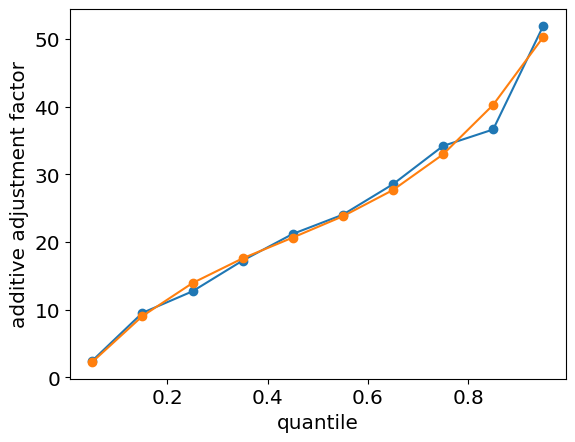

In [46]:
plt.plot(quantile_array, bias_quantile_add, marker='o')
cubic_data = np.polyval(bias_quantile_add_cubic_fit, quantile_array)
plt.plot(quantile_array, cubic_data, marker='o')
plt.xlabel('quantile')
plt.ylabel('additive adjustment factor')
plt.show()

In [47]:
bias_quantile_mulc = da_model_detrended_q.values / da_obs_detrended_q.values

In [48]:
bias_quantile_mulc_cubic_fit = np.polyfit(quantile_array, bias_quantile_mulc, 3)

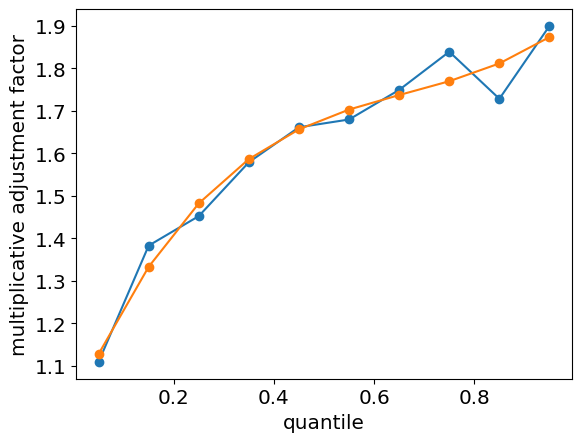

In [49]:
plt.plot(quantile_array, bias_quantile_mulc, marker='o')
cubic_data = np.polyval(bias_quantile_mulc_cubic_fit, quantile_array)
plt.plot(quantile_array, cubic_data, marker='o')
plt.xlabel('quantile')
plt.ylabel('multiplicative adjustment factor')
plt.show()

In [50]:
#def get_adjustment_factor(value, quantiles, adjustment_factors):
#    """Find the adjustment factor corresponding to the closest quantile."""
#
#    assert quantiles.shape == adjustment_factors.shape
#    
#    difference_array = np.absolute(quantiles - value)
#    index = difference_array.argmin()
#    adjustment_factor = adjustment_factors[index]
#
#    return adjustment_factor
#
#vget_adjustment_factor = np.vectorize(get_adjustment_factor, excluded=['quantiles', 'adjustment_factors'])


def get_smooth_adjustment_factor(value, data, af_cubic_fit):
    """Find the adjustment factor."""

    quantile = stats.percentileofscore(data, value) / 100
    af = np.polyval(af_cubic_fit, quantile)

    return af

vget_smooth_adjustment_factor = np.vectorize(get_smooth_adjustment_factor, excluded=['data', 'af_cubic_fit'])

#### Additive

In [51]:
af_add = vget_smooth_adjustment_factor(
    da_model_detrended_stacked.values,
    data=da_model_detrended_stacked.values,
    af_cubic_fit=bias_quantile_add_cubic_fit,
)

In [52]:
da_model_detrended_bc_quantile_add = da_model_detrended_stacked - af_add

In [53]:
gev_shape_model_detrended_bc_quantile_add, gev_loc_model_detrended_bc_quantile_add, gev_scale_model_detrended_bc_quantile_add = eva.fit_gev(da_model_detrended_bc_quantile_add.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_quantile_add:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_quantile_add:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_quantile_add:.2f}')

Shape parameter: -0.09
Location parameter: 30.53
Scale parameter: 8.60


#### Multiplicative

In [54]:
af_mulc = vget_smooth_adjustment_factor(
    da_model_detrended_stacked.values,
    data=da_model_detrended_stacked.values,
    af_cubic_fit=bias_quantile_mulc_cubic_fit,
)

In [55]:
da_model_detrended_bc_quantile_mulc = da_model_detrended_stacked / af_mulc

In [56]:
gev_shape_model_detrended_bc_quantile_mulc, gev_loc_model_detrended_bc_quantile_mulc, gev_scale_model_detrended_bc_quantile_mulc = eva.fit_gev(da_model_detrended_bc_quantile_mulc.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_quantile_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_quantile_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_quantile_mulc:.2f}')

Shape parameter: -0.01
Location parameter: 30.78
Scale parameter: 8.96


## Comparison

In [57]:
def fidelity_tests(da_target):
    """Perform fidelity tests."""
    
    similarity_scores = similarity.similarity_tests(da_target, da_obs)
    print('KS score:', similarity_scores['ks_statistic'].values)
    print('KS p-value:', similarity_scores['ks_pval'].values)
    print('AD score:', similarity_scores['ad_statistic'].values)
    print('AD p-value:', similarity_scores['ad_pval'].values)

    moments.create_plot(
        da_model_detrended,
        da_obs_detrended,
        da_bc_fcst=da_target,
    )

In [58]:
xmax = np.max([da_model_detrended_stacked.values.max(), da_obs_detrended.values.max()]) + 1
xmin = np.min([da_model_detrended_stacked.values.min(), da_obs_detrended.values.min()]) - 1

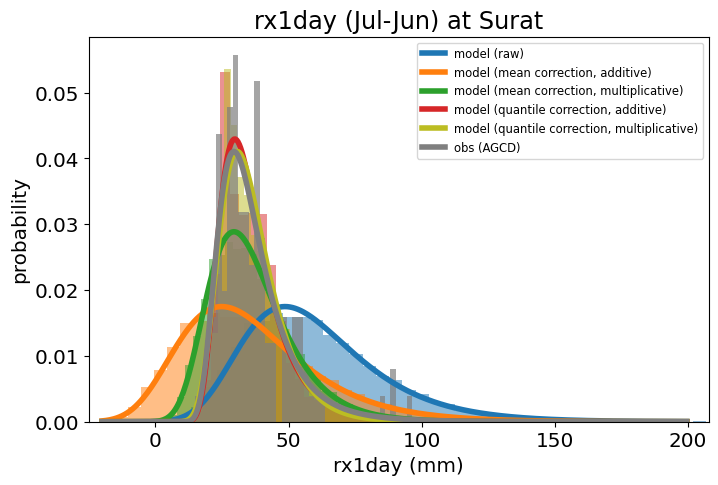

In [74]:
fig, ax = plt.subplots(figsize=[8, 5])
gev_xvals = np.arange(-20, 200, 0.5)

da_model_detrended_stacked.plot.hist(bins=40, density=True, color='tab:blue', alpha=0.5)
gev_pdf_model_detrended = gev.pdf(gev_xvals, gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended)
plt.plot(gev_xvals, gev_pdf_model_detrended, color='tab:blue', linewidth=4.0, label='model (raw)')

da_model_detrended_bc_mean_add_stacked.plot.hist(bins=40, density=True, color='tab:orange', alpha=0.5)
gev_pdf_model_detrended_bc_mean_add = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_mean_add,
    gev_loc_model_detrended_bc_mean_add,
    gev_scale_model_detrended_bc_mean_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_mean_add,
    color='tab:orange',
    linewidth=4.0,
    label='model (mean correction, additive)'
)

da_model_detrended_bc_mean_mulc_stacked.plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
gev_pdf_model_detrended_bc_mean_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_mean_mulc,
    gev_loc_model_detrended_bc_mean_mulc,
    gev_scale_model_detrended_bc_mean_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_mean_mulc,
    color='tab:green',
    linewidth=4.0,
    label='model (mean correction, multiplicative)'
)

da_model_detrended_bc_quantile_add.plot.hist(bins=40, density=True, color='tab:red', alpha=0.5)
gev_pdf_model_detrended_bc_quantile_add = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_quantile_add,
    gev_loc_model_detrended_bc_quantile_add,
    gev_scale_model_detrended_bc_quantile_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_quantile_add,
    color='tab:red',
    linewidth=4.0,
    label='model (quantile correction, additive)'
)

da_model_detrended_bc_quantile_mulc.plot.hist(bins=40, density=True, color='tab:olive', alpha=0.5)
gev_pdf_model_detrended_bc_quantile_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_quantile_mulc,
    gev_loc_model_detrended_bc_quantile_mulc,
    gev_scale_model_detrended_bc_quantile_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_quantile_mulc,
    color='tab:olive',
    linewidth=4.0,
    label='model (quantile correction, multiplicative)'
)

da_obs_detrended.plot.hist(bins=40, density=True, color='tab:gray', alpha=0.7)
gev_pdf_obs_detrended = gev.pdf(gev_xvals, gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended)
plt.plot(gev_xvals, gev_pdf_obs_detrended, color='tab:gray', linewidth=4.0, label='obs (AGCD)')

plt.xlabel('rx1day (mm)')
plt.ylabel('probability')
plt.title(f'rx1day (Jul-Jun) at {location}')

plt.xlim(-25, xmax)
plt.legend(fontsize='small')
plt.savefig(f'rx1day_{location}_gevs.png', bbox_inches='tight', facecolor='white')
plt.show()

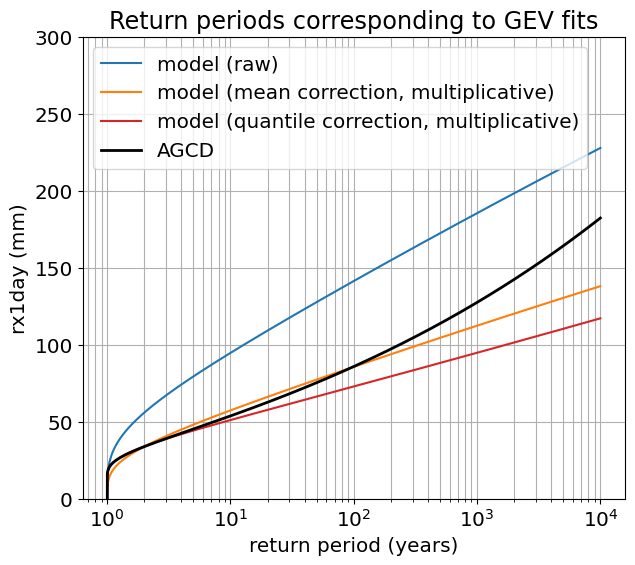

In [76]:
fig = plt.figure(figsize=[7, 6])
#ax1 = fig.add_subplot(211)
#ax2 = fig.add_subplot(212)
ax2 = fig.add_subplot(111)

#ax1.plot(gev_xvals, gev_pdf_model_detrended, color='tab:blue', label='model (raw)')
return_periods_model_detrended, return_values_model_detrended = stability.return_curve(
    da_model_detrended,
    'gev',
    params=[gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended],
)
ax2.plot(return_periods_model_detrended, return_values_model_detrended, label='model (raw)', color='tab:blue')

#ax1.plot(gev_xvals, gev_pdf_model_detrended_bc_mean_mulc, color='tab:orange', label='model (mean correction, multiplicative)')
return_periods_model_detrended_bc_mean_mulc, return_values_model_detrended_bc_mean_mulc = stability.return_curve(
    da_model_detrended_bc_mean_mulc,
    'gev',
    params=[gev_shape_model_detrended_bc_mean_mulc, gev_loc_model_detrended_bc_mean_mulc, gev_scale_model_detrended_bc_mean_mulc],
)
ax2.plot(
    return_periods_model_detrended_bc_mean_mulc,
    return_values_model_detrended_bc_mean_mulc,
    label='model (mean correction, multiplicative)',
    color='tab:orange'
)

#ax1.plot(gev_xvals, gev_pdf_model_detrended_bc_quantile_mulc, color='tab:red', label='model (quantile correction, multiplicative)')
return_periods_model_detrended_bc_quantile_mulc, return_values_model_detrended_bc_quantile_mulc = stability.return_curve(
    da_model_detrended_bc_quantile_mulc,
    'gev',
    params=[gev_shape_model_detrended_bc_quantile_mulc, gev_loc_model_detrended_bc_quantile_mulc, gev_scale_model_detrended_bc_quantile_mulc],
)
ax2.plot(
    return_periods_model_detrended_bc_quantile_mulc,
    return_values_model_detrended_bc_quantile_mulc,
    label='model (quantile correction, multiplicative)',
    color='tab:red'
)

#ax1.plot(gev_xvals, gev_pdf_obs_detrended, color='black', linewidth=2.0, label='AGCD')
return_periods_obs_detrended, return_values_obs_detrended = stability.return_curve(
    da_obs_detrended,
    'gev',
    params=[gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended],
)
ax2.plot(return_periods_obs_detrended, return_values_obs_detrended, label='AGCD', color='black', linewidth=2.0)

#ax1.grid()
#ax1.set_xlabel('TXx (C)')
#ax1.set_ylabel('probability')
#ax1.axvline(agcd_max, color='0.5', linestyle='--')
#ax1.set_title('(a) GEV fit to data')
#ax1.set_xlim([0, 450])
#ax1.legend()

ax2.legend()
#ax2.axhline(agcd_max, color='0.5', linestyle='--')
ax2.set_xscale('log')
ax2.set_xlabel('return period (years)')
ax2.set_ylabel('rx1day (mm)')
ax2.set_title('Return periods corresponding to GEV fits')
ax2.set_ylim([0, 300])
ax2.grid(which='both')
plt.savefig(f'rx1day_{location}_return_curves.png', bbox_inches='tight', facecolor='white')
plt.show()

### Raw data

In [61]:
similarity_ds = similarity.similarity_tests(da_model_detrended, da_obs_detrended)
print('KS score:', similarity_ds['ks_statistic'].values)
print('KS p-value:', similarity_ds['ks_pval'].values)
print('AD score:', similarity_ds['ad_statistic'].values)
print('AD p-value:', similarity_ds['ad_pval'].values)

KS score: 0.504928
KS p-value: 2.501866e-29
AD score: 89.97319
AD p-value: 0.001


### Additive - mean correction

KS score: 0.27917558
KS p-value: 6.69379e-09
AD score: 16.94977
AD p-value: 0.001


INFO:root:mean: Obs = 36.95519256591794, Model 95% CI =55.869518800474275 to 64.79777880767251
INFO:root:standard deviation: Obs = 14.072709314709599, Model 95% CI =22.132519004723633 to 30.361798414055947
INFO:root:skew: Obs = 1.8360945063325902, Model 95% CI =0.39409139151671996 to 1.5201158664386178
INFO:root:kurtosis: Obs = 4.570226833766197, Model 95% CI =-0.46332200691133213 to 4.230945751471863
INFO:root:GEV shape: Obs = -0.11993963394779131, Model 95% CI =-0.10450744994034454 to 0.15039052366480501
INFO:root:GEV location: Obs = 30.519318919864368, Model 95% CI =44.29895202795168 to 52.87858478256734
INFO:root:GEV scale: Obs = 9.022500181367377, Model 95% CI =18.190416836592412 to 23.63065115787413
INFO:root:mean: Obs = 36.95519256591794, Bias corrected model 95% CI =31.8067570059978 to 41.34413846814992
INFO:root:standard deviation: Obs = 14.072709314709599, Bias corrected model 95% CI =21.86627792158282 to 30.322238587125046
INFO:root:skew: Obs = 1.8360945063325902, Bias corre

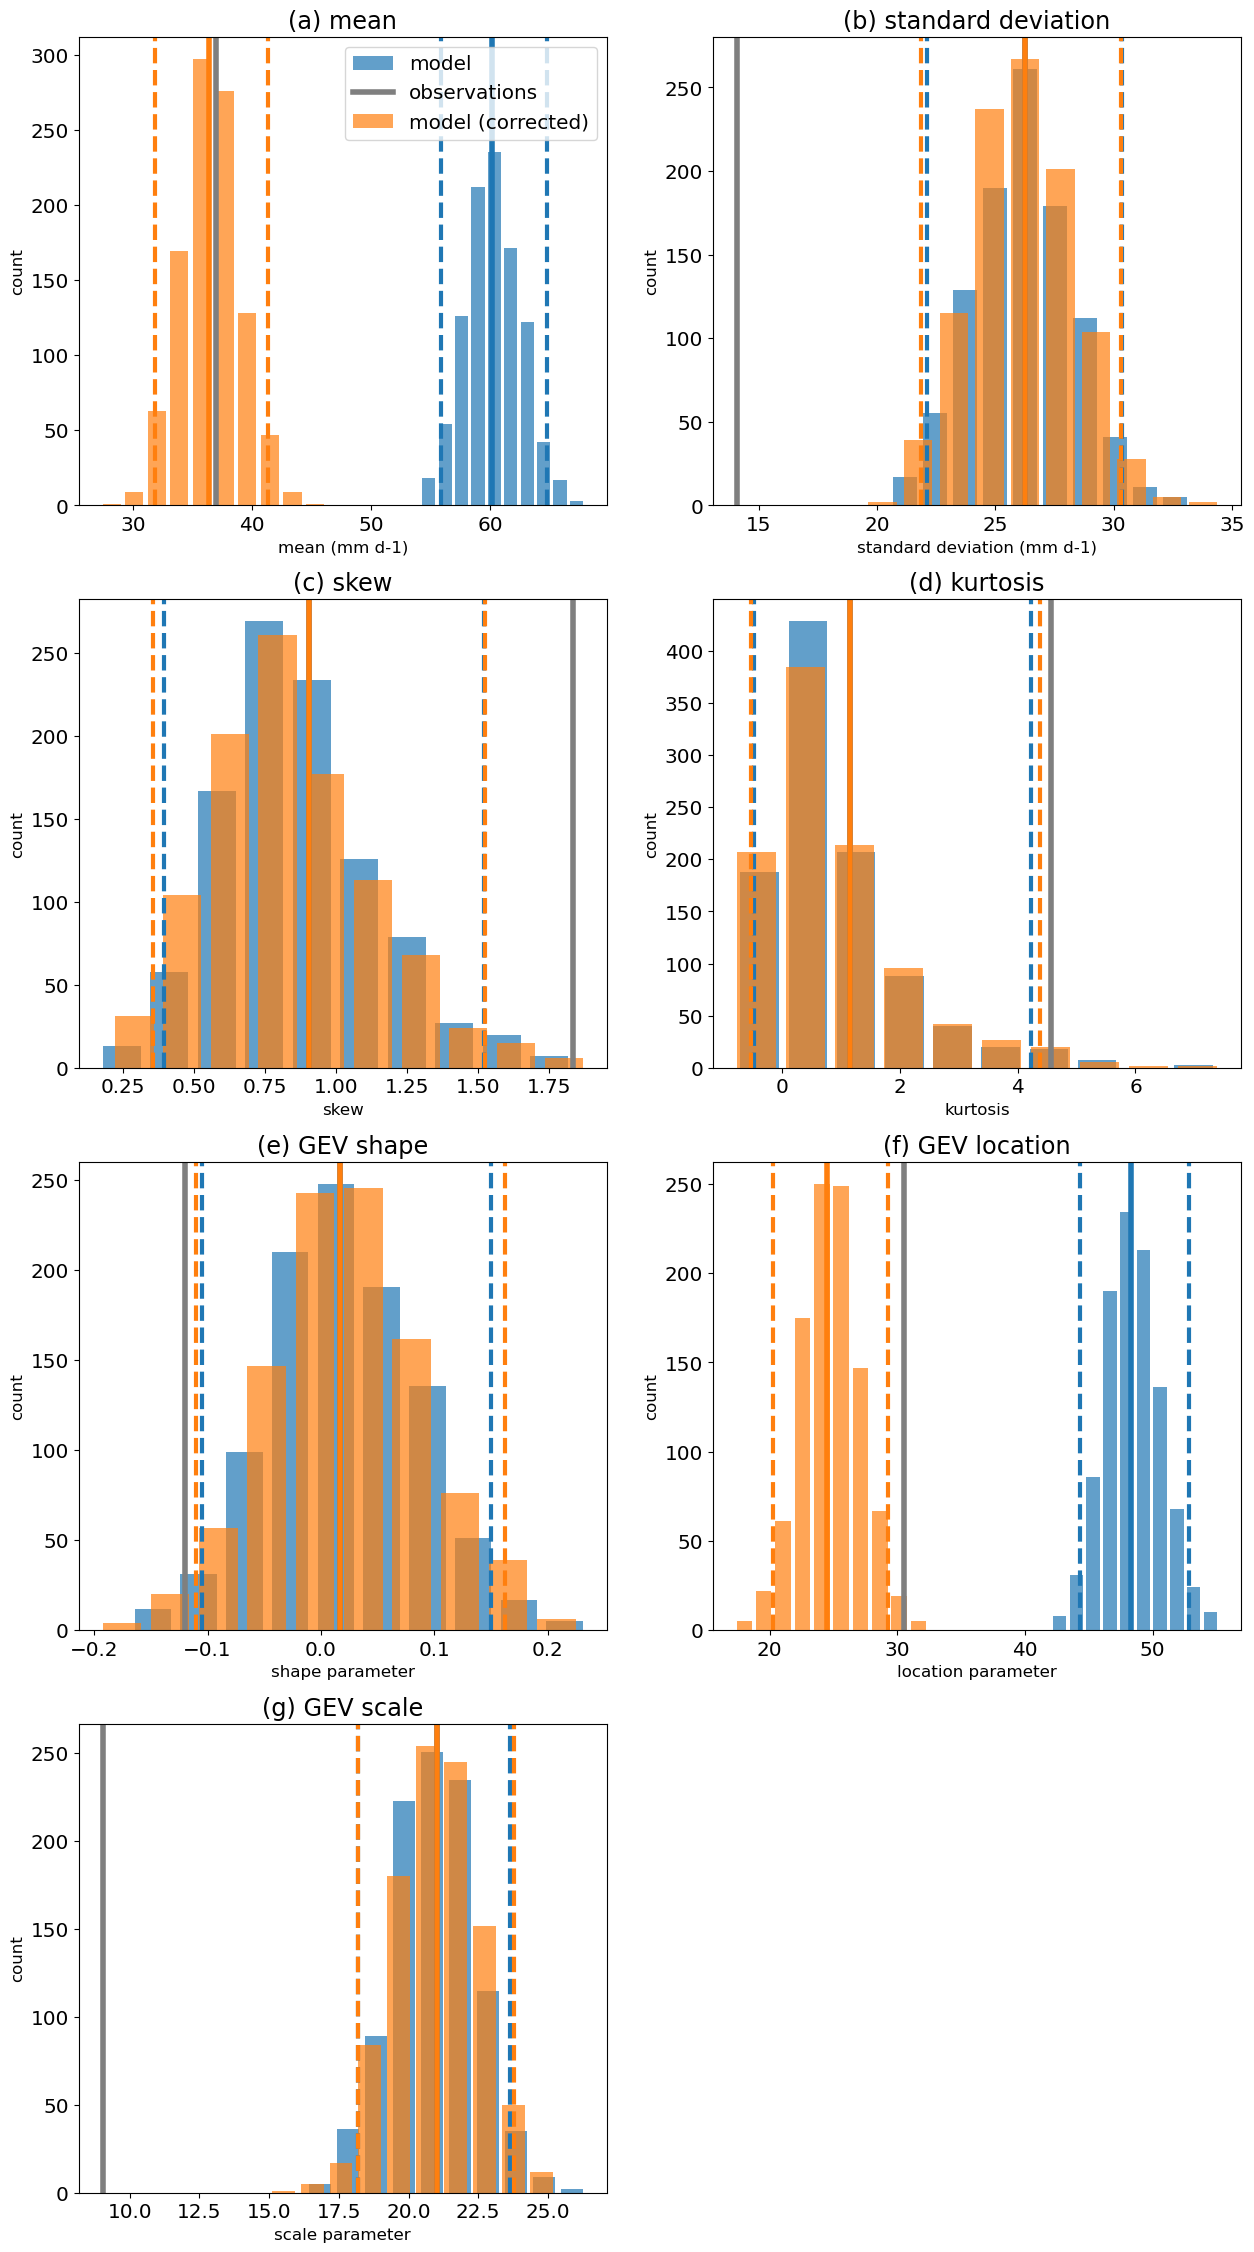

In [62]:
fidelity_tests(da_model_detrended_bc_mean_add)

### Multiplicative - mean correction

KS score: 0.13798079
KS p-value: 0.017317267
AD score: 3.3496509
AD p-value: 0.014252944


INFO:root:mean: Obs = 36.95519256591794, Model 95% CI =55.319122573860234 to 64.65475779004127
INFO:root:standard deviation: Obs = 14.072709314709599, Model 95% CI =22.294147278766278 to 30.290683016936285
INFO:root:skew: Obs = 1.8360945063325902, Model 95% CI =0.36190216396399144 to 1.5114791087471338
INFO:root:kurtosis: Obs = 4.570226833766197, Model 95% CI =-0.5384741937992211 to 4.077108469338609
INFO:root:GEV shape: Obs = -0.11993963394779131, Model 95% CI =-0.11521795317491873 to 0.15504355591014782
INFO:root:GEV location: Obs = 30.519318919864368, Model 95% CI =44.23700784095998 to 52.94468740374527
INFO:root:GEV scale: Obs = 9.022500181367377, Model 95% CI =17.723313155542016 to 23.766197100553626
INFO:root:mean: Obs = 36.95519256591794, Bias corrected model 95% CI =33.8773228441602 to 39.11171267647343
INFO:root:standard deviation: Obs = 14.072709314709599, Bias corrected model 95% CI =13.43999716148319 to 18.334716286171947
INFO:root:skew: Obs = 1.8360945063325902, Bias corre

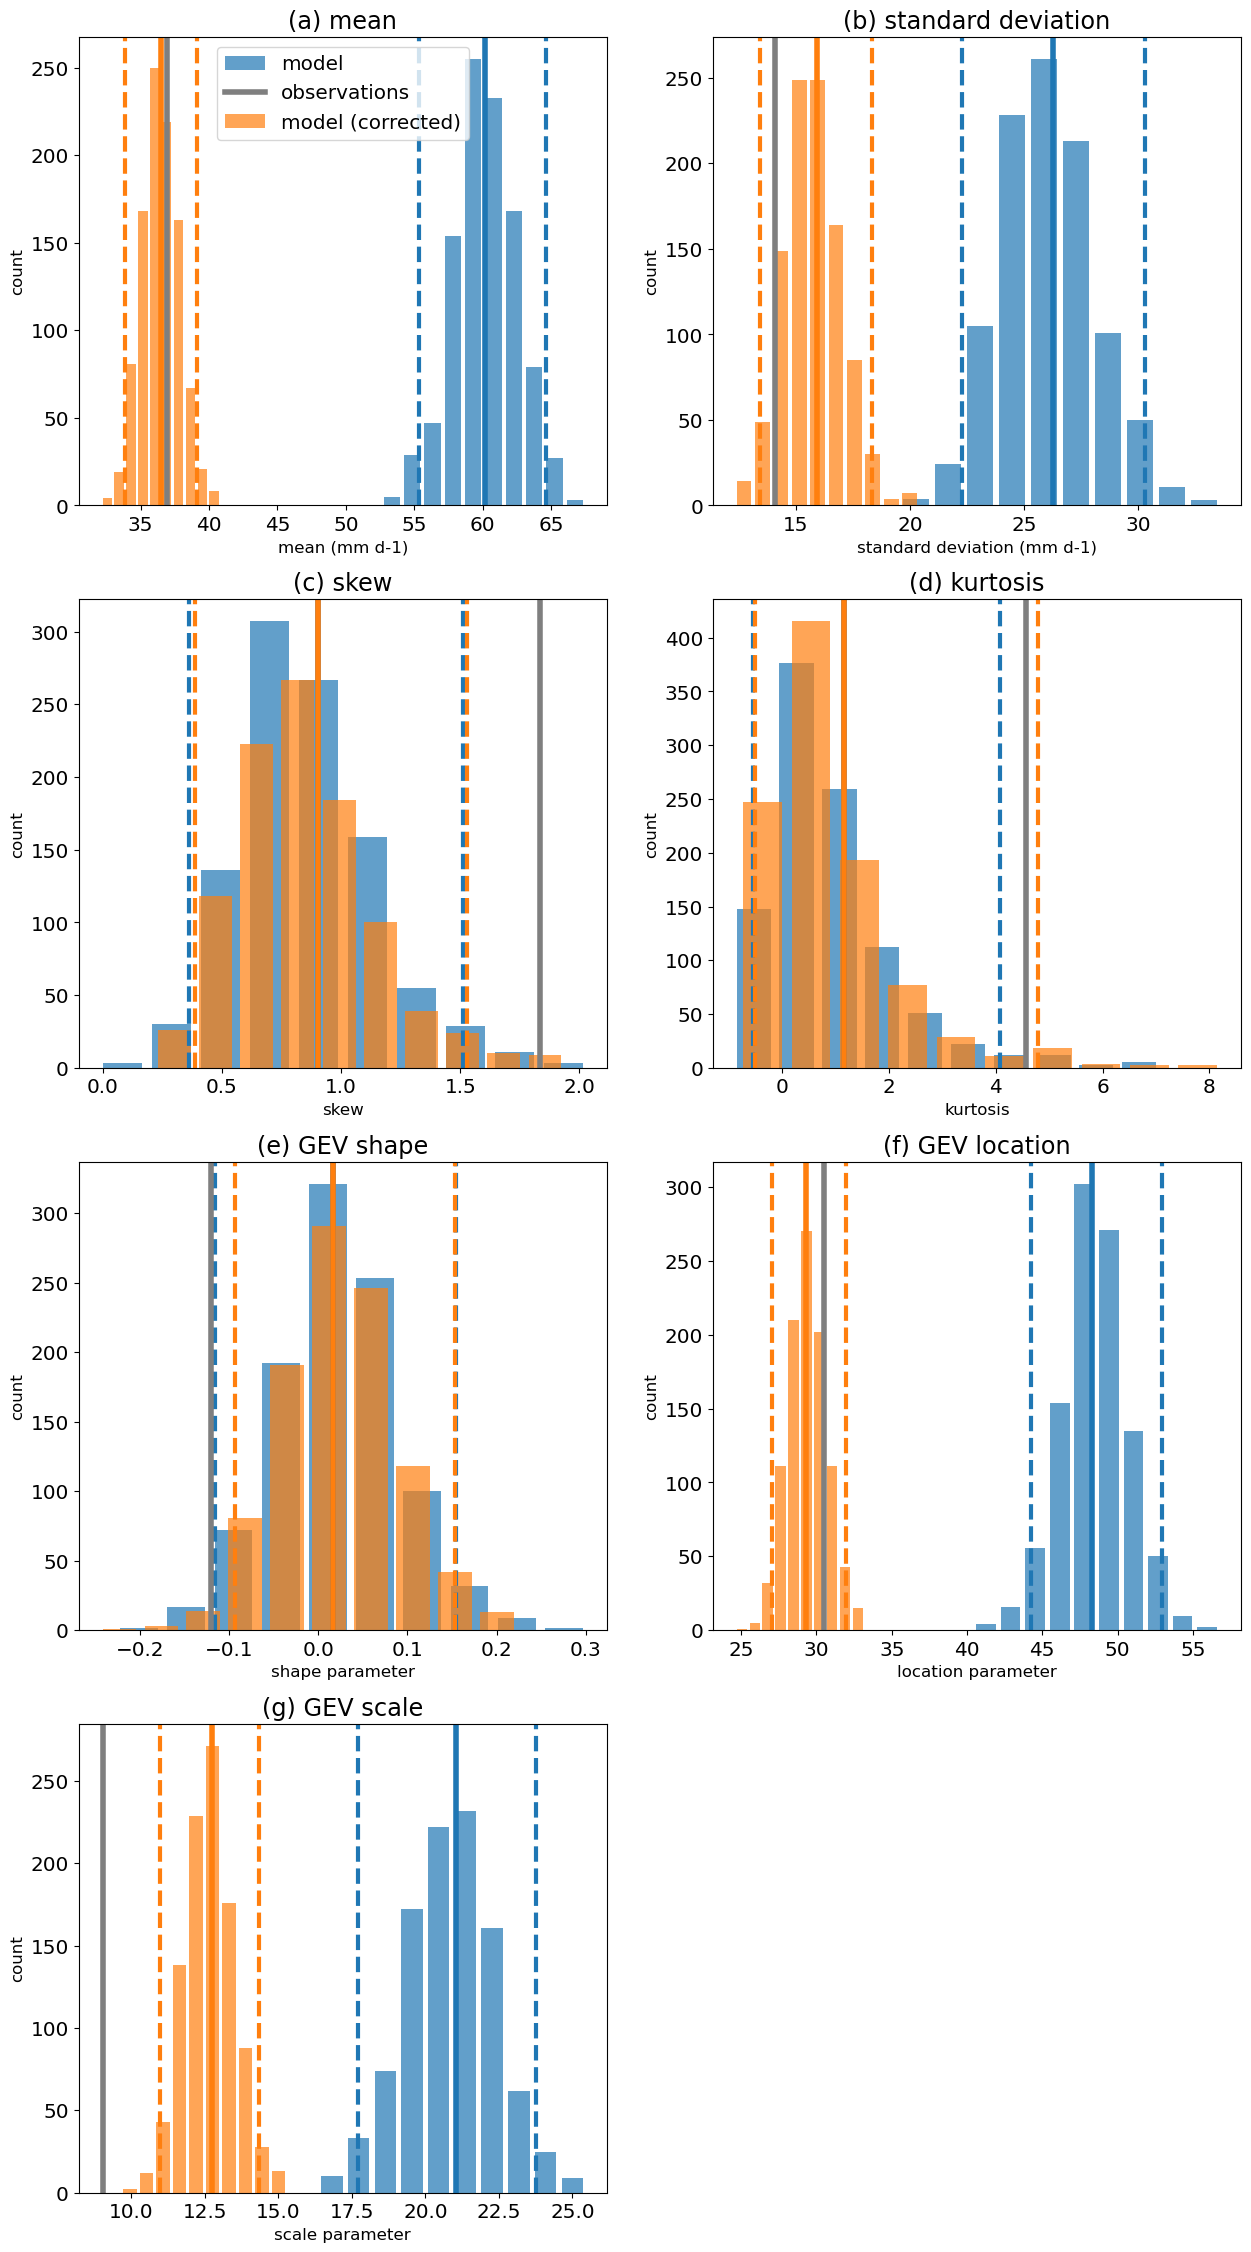

In [63]:
fidelity_tests(da_model_detrended_bc_mean_mulc)

### Additive - quantile correction

KS score: 0.06081396
KS p-value: 0.73422927
AD score: -0.36835214
AD p-value: 0.25


INFO:root:mean: Obs = 36.95519256591794, Model 95% CI =55.52131570238258 to 65.2270151817669
INFO:root:standard deviation: Obs = 14.072709314709599, Model 95% CI =21.874970453689446 to 30.46208353377708
INFO:root:skew: Obs = 1.8360945063325902, Model 95% CI =0.35654582521806666 to 1.49482522668932
INFO:root:kurtosis: Obs = 4.570226833766197, Model 95% CI =-0.49590529181187143 to 4.312561015481464
INFO:root:GEV shape: Obs = -0.11993963394779131, Model 95% CI =-0.11011485957489127 to 0.1615143793505945
INFO:root:GEV location: Obs = 30.519318919864368, Model 95% CI =44.357564316500074 to 53.05551349242438
INFO:root:GEV scale: Obs = 9.022500181367377, Model 95% CI =17.971794740645137 to 23.980575667104578
INFO:root:mean: Obs = 36.95519256591794, Bias corrected model 95% CI =34.06128836172922 to 38.53537397431114
INFO:root:standard deviation: Obs = 14.072709314709599, Bias corrected model 95% CI =9.717947063041228 to 16.310068006963082
INFO:root:skew: Obs = 1.8360945063325902, Bias correcte

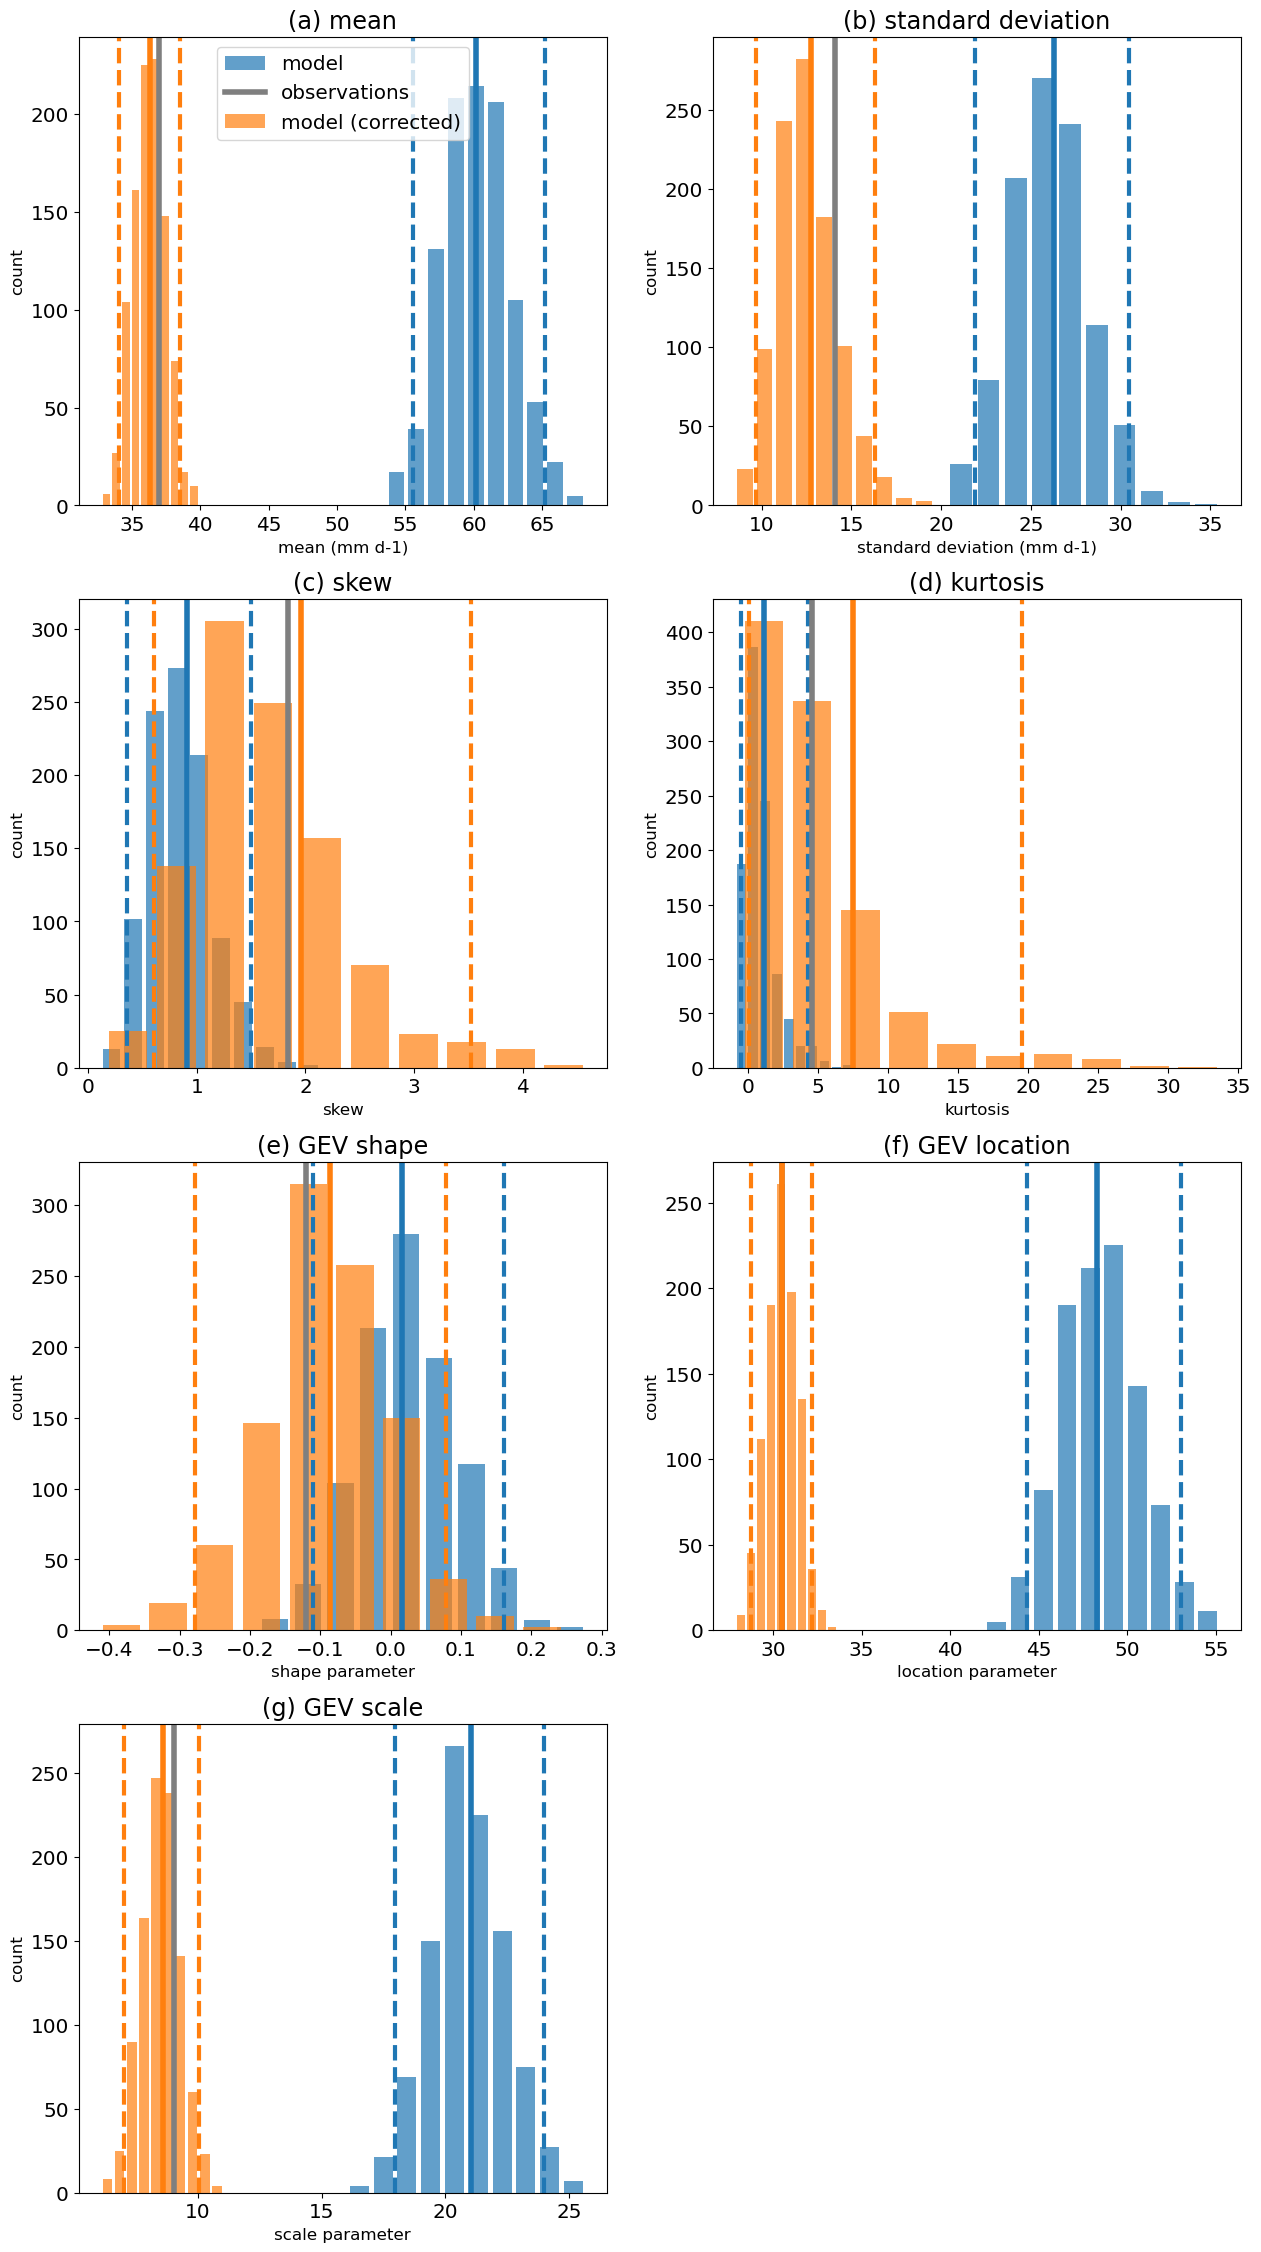

In [64]:
fidelity_tests(da_model_detrended_bc_quantile_add.unstack())

### Multiplicative - quantile correction

KS score: 0.047689345
KS p-value: 0.93169105
AD score: -0.5545613
AD p-value: 0.25


INFO:root:mean: Obs = 36.95519256591794, Model 95% CI =55.79860313951115 to 64.90372556557789
INFO:root:standard deviation: Obs = 14.072709314709599, Model 95% CI =22.24414292952157 to 30.217530153485985
INFO:root:skew: Obs = 1.8360945063325902, Model 95% CI =0.36740565413024445 to 1.520616155626521
INFO:root:kurtosis: Obs = 4.570226833766197, Model 95% CI =-0.5569845317290373 to 4.416706434092645
INFO:root:GEV shape: Obs = -0.11993963394779131, Model 95% CI =-0.09653440336469521 to 0.157737849070338
INFO:root:GEV location: Obs = 30.519318919864368, Model 95% CI =44.31184961221252 to 52.74401646805985
INFO:root:GEV scale: Obs = 9.022500181367377, Model 95% CI =18.187763031995168 to 23.750751212479678
INFO:root:mean: Obs = 36.95519256591794, Bias corrected model 95% CI =33.949190494040494 to 38.211593264984984
INFO:root:standard deviation: Obs = 14.072709314709599, Bias corrected model 95% CI =9.793530866307972 to 13.596515542890366
INFO:root:skew: Obs = 1.8360945063325902, Bias correct

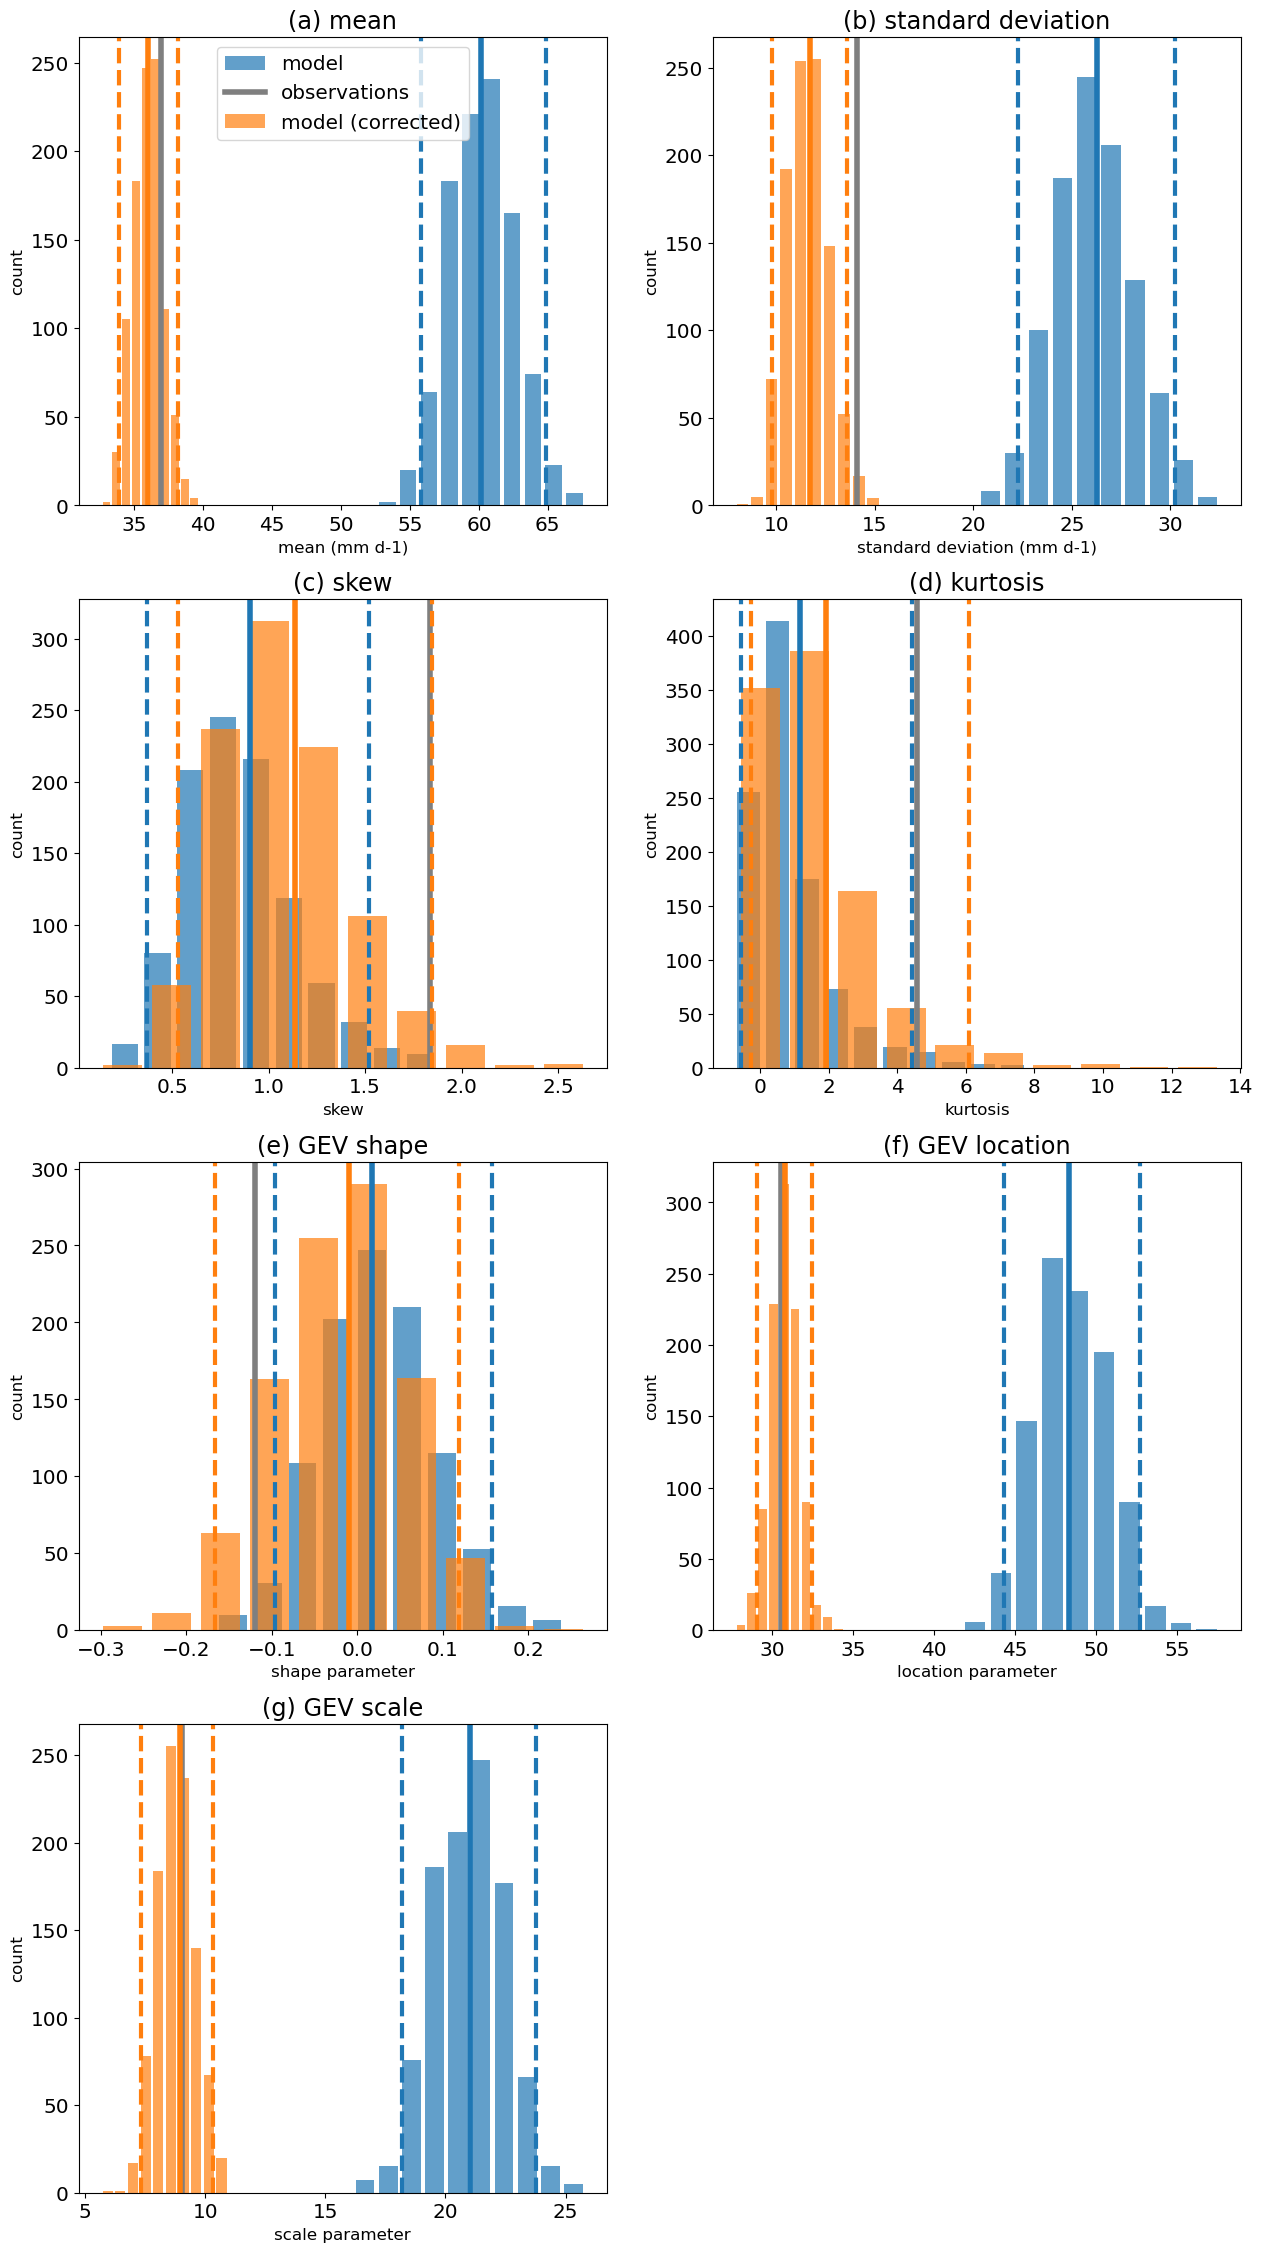

In [65]:
fidelity_tests(da_model_detrended_bc_quantile_mulc.unstack())